# EEG Motor Imagery Classification – Clean Notebook


## 1. Imports

In [2]:
import scipy.io
import numpy as np
import mne
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from braindecode.models import ShallowFBCSPNet
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## 2. Data Loading and Epoching

We load .mat EEG files and convert them into MNE Raw objects.
We then extract events and create epochs corresponding to motor imagery tasks (e.g., left hand, right hand, tongue, etc.).
This step converts continuous EEG signals into trial-based data segments suitable for training.

After experimenting with several pipelines, we decided to keep preprocessing minimal.
We do not apply windowing or additional filtering here.

In [3]:
files = [
    "data/raw_mat/HaLTSubjectA1602236StLRHandLegTongue.mat",
    "data/raw_mat/HaLTSubjectA1603086StLRHandLegTongue.mat",
]

all_epochs = []
for f in files:
    mat = scipy.io.loadmat(f)
    content = mat['o'][0, 0]

    labels = content[4].flatten()
    signals = content[5]
    chan_names_raw = content[6]
    channels = [ch[0][0] for ch in chan_names_raw]
    fs = int(content[2][0, 0])

    import pandas as pd
    df = pd.DataFrame(signals, columns=channels).drop(columns=["X5"], errors="ignore")
    eeg = df.values.T
    ch_names = df.columns.tolist()

    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types="eeg")
    raw = mne.io.RawArray(eeg, info)
    

    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    raw.set_eeg_reference(projection=True)

    onsets = np.where((labels[1:] != 0) & (labels[:-1] == 0))[0] + 1
    event_codes = labels[onsets].astype(int)
    events = np.c_[onsets, np.zeros_like(onsets), event_codes]

    mask = np.isin(events[:, 2], np.arange(1, 7))
    events = events[mask]

    event_id = {
        "left_hand": 1,
        "right_hand": 2,
        "neutral": 3,
        "left_leg": 4,
        "tongue": 5,
        "right_leg": 6,
    }

    epochs = mne.Epochs(
        raw,
        events=events,
        event_id=event_id,
        tmin=0,
        tmax=1.5,
        baseline=None,
        preload=True,
    )

    all_epochs.append(epochs)

epochs_all = mne.concatenate_epochs(all_epochs)


Creating RawArray with float64 data, n_channels=21, n_times=667600
    Range : 0 ... 667599 =      0.000 ...  3337.995 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Not setting metadata
959 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 959 events and 301 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=21, n_times=681400
    Range : 0 ... 681399 =      0.000 ...  3406.995 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Not setting metadata
958 matchi

## 3. Split

We apply a random stratified split (80/20).
This ensures balanced classes while allowing us to study brain patterns related to imagined movements.

In [4]:
X = epochs_all.get_data().astype("float32")   # shape (N, C, T)
y = (epochs_all.events[:, -1] - 1).astype("int64")  # classes 0..5

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 4. Torch DataLoaders
We prepare TensorDatasets and DataLoaders for PyTorch training.

In [5]:
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)


## 5. Model – Shallow ConvNet

We use ShallowFBCSPNet, as it showed the best performance in our experiments.
Reference: Schirrmeister et al., 2017:  https://onlinelibrary.wiley.com/doi/epdf/10.1002/hbm.23730
In addition, we load pretrained weights from a saved file to initialize the model parameters before training.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ShallowFBCSPNet(
    n_chans=X.shape[1],
    n_outputs=len(np.unique(y)),
    n_times=X.shape[2],
    final_conv_length="auto"
).to(device)

# Load pretrained weights
state_dict = torch.load("shallow_weights_all.pth", map_location=device)
model.load_state_dict(state_dict)


<All keys matched successfully>

## 6. Training

We train for 20 epochs with CrossEntropyLoss and Adam optimizer.

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 21):
    # --- training ---
    model.train()
    correct, total = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    train_acc = correct / total

    # --- validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            pred = out.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch:02d} | Train acc: {train_acc:.3f} | Val acc: {val_acc:.3f}")


Epoch 01 | Train acc: 0.753 | Val acc: 0.833
Epoch 02 | Train acc: 0.797 | Val acc: 0.852
Epoch 03 | Train acc: 0.825 | Val acc: 0.846
Epoch 04 | Train acc: 0.841 | Val acc: 0.852
Epoch 05 | Train acc: 0.870 | Val acc: 0.849
Epoch 06 | Train acc: 0.882 | Val acc: 0.849
Epoch 07 | Train acc: 0.883 | Val acc: 0.846
Epoch 08 | Train acc: 0.885 | Val acc: 0.862
Epoch 09 | Train acc: 0.890 | Val acc: 0.854
Epoch 10 | Train acc: 0.908 | Val acc: 0.859
Epoch 11 | Train acc: 0.909 | Val acc: 0.844
Epoch 12 | Train acc: 0.918 | Val acc: 0.859
Epoch 13 | Train acc: 0.928 | Val acc: 0.854
Epoch 14 | Train acc: 0.912 | Val acc: 0.862
Epoch 15 | Train acc: 0.915 | Val acc: 0.867
Epoch 16 | Train acc: 0.921 | Val acc: 0.857
Epoch 17 | Train acc: 0.936 | Val acc: 0.865
Epoch 18 | Train acc: 0.922 | Val acc: 0.865
Epoch 19 | Train acc: 0.939 | Val acc: 0.867
Epoch 20 | Train acc: 0.935 | Val acc: 0.859


## 7. Evaluation
We compute and display a confusion matrix on the validation set.

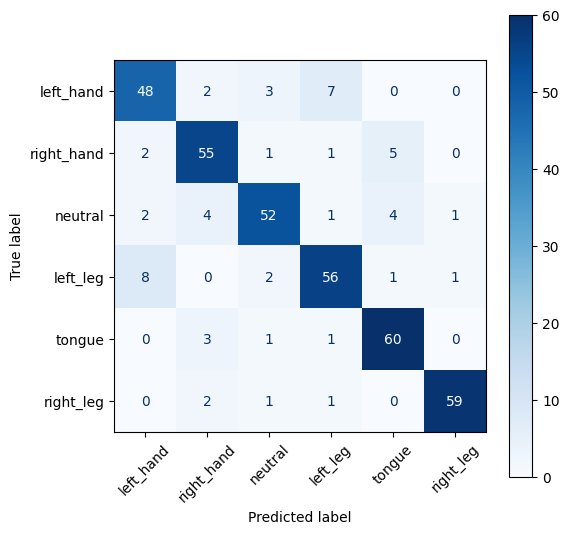

In [8]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        pred = out.argmax(dim=1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(pred)

labels_names = ["left_hand", "right_hand", "neutral", "left_leg", "tongue", "right_leg"]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.show()


## 8. Testing on Separate Subject

Finally, we test the trained model on a separate data file to evaluate its generalization performance and visualize predictions with a confusion matrix.

Creating RawArray with float64 data, n_channels=21, n_times=813600
    Range : 0 ... 813599 =      0.000 ...  4067.995 secs
Ready.
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 301 original time points ...
0 bad epochs dropped
Test accuracy: 0.847


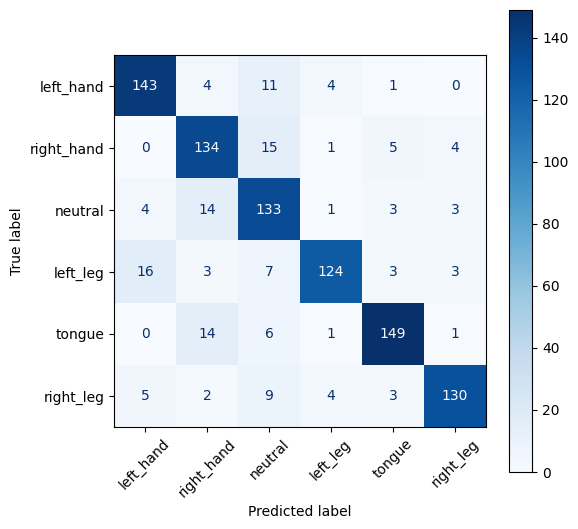

In [9]:
# Load test file
test_file = "data/raw_mat/HaLTSubjectA1603106StLRHandLegTongue.mat"
mat = scipy.io.loadmat(test_file)
content = mat['o'][0, 0]

labels = content[4].flatten()
signals = content[5]
chan_names_raw = content[6]
channels = [ch[0][0] for ch in chan_names_raw]
fs = int(content[2][0, 0])

df = pd.DataFrame(signals, columns=channels).drop(columns=["X5"], errors="ignore")
eeg = df.values.T
ch_names = df.columns.tolist()

info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types="eeg")
raw = mne.io.RawArray(eeg, info)

# Create events and epochs
onsets = np.where((labels[1:] != 0) & (labels[:-1] == 0))[0] + 1
event_codes = labels[onsets].astype(int)
events = np.c_[onsets, np.zeros_like(onsets), event_codes]

mask = np.isin(events[:, 2], np.arange(1, 7))
events = events[mask]

event_id = {
    "left_hand": 1,
    "right_hand": 2,
    "neutral": 3,
    "left_leg": 4,
    "tongue": 5,
    "right_leg": 6,
}

epochs_test = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=0,
    tmax=1.5,
    baseline=None,
    preload=True,
)

# Prepare test data
X_test = epochs_test.get_data().astype("float32")
y_test = (epochs_test.events[:, -1] - 1).astype("int64")

test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = DataLoader(test_ds, batch_size=32)

# Evaluate
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        out = model(xb.to(device))
        pred = out.argmax(dim=1).cpu()
        y_true.extend(yb.numpy())
        y_pred.extend(pred.numpy())

test_acc = (np.array(y_true) == np.array(y_pred)).mean()
print(f"Test accuracy: {test_acc:.3f}")

# Confusion matrix with labels
labels_names = ["left_hand", "right_hand", "neutral", "left_leg", "tongue", "right_leg"]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
plt.show()
